# Feature Selection

In [11]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score,homogeneity_completeness_v_measure,silhouette_score, accuracy_score
from scipy.stats import kurtosis
from sklearn.mixture import GaussianMixture
from itertools import groupby
import operator
import csv
from sklearn.cluster import KMeans

In [2]:
def get_score(model, X, y, mapper):
    pred = model.predict(X)
    pred_act = [mapper[i] for i in pred]
    return accuracy_score(pred_act, y)

# Wine Dataset

In [3]:
def get_cat(x):
    if x < 6: return 'bad'
    else: return 'good'


def get_data(file):
    data = pd.read_csv(file)
    categorical_vars =["class"]
    
    df = data.copy()
    
    for var, value in df.iteritems():
        if var not in categorical_vars:
            df[var] = (df[var]-df[var].mean())/df[var].std()

    return df

df = get_data("wine_dataset.csv")

y = df['class'].values
X = df.drop(['class'], axis=1)
df.tail()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Od_Hod_of_diluted_wines,Proline
3152,3,0.415589,0.254163,0.188519,3.001047,-0.340468,-1.146502,-1.467846,0.287709,-0.901624,1.099993,1.517704,-1.723028,-0.287231
3153,1,-0.756533,-0.542201,-0.512479,3.064172,1.297913,-0.159682,0.250942,0.498601,-1.231649,-0.155276,-0.175866,1.216221,1.841367
3154,1,0.504843,-0.492588,1.895604,3.138160,0.579143,0.642725,0.761415,1.799971,1.106230,0.424051,1.188602,0.043996,2.097635
3155,3,0.909479,1.613956,1.870913,3.159155,-0.729241,0.561769,0.666325,1.139906,1.062602,-0.069268,-0.449447,-0.851747,-0.117785
3156,1,0.608583,-0.769603,1.569281,3.231870,0.756223,2.336953,-0.203921,-0.848322,-0.042762,-0.317905,-0.615134,0.382382,0.845015


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [5]:
forest = ExtraTreesClassifier(n_estimators = 250)
forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250)

In [6]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

1. Proline (0.168067)
2. Od_Hod_of_diluted_wines (0.147993)
3. Alcohol (0.119255)
4. Color_intensity (0.112771)
5. Hue (0.097455)
6. Total_phenols (0.081660)
7. Flavanoids (0.076946)
8. Malic_acid (0.058474)
9. Magnesium (0.037955)
10. Nonflavanoid_phenols (0.029475)
11. Alcalinity_of_ash (0.024836)
12. Proanthocyanins (0.024178)
13. Ash (0.020935)


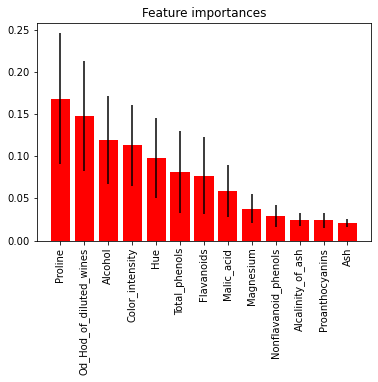

In [7]:
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(X.columns[indices], importances[indices],
        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xticks(rotation='vertical')
plt.show()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


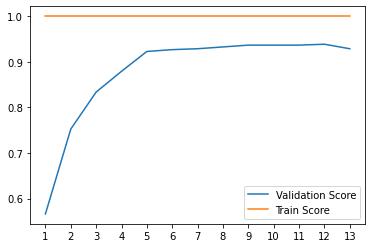

In [8]:
X_train_1, X_test_1, y_train_1, y_test_1 = \
    train_test_split(X_train, y_train, test_size=0.20, random_state=7)
train_score = []
test_score = []
for i, index in enumerate(indices):
    X_train_dup = X_train_1[X_train_1.columns[indices[:i+1]]]
    X_test_dup = X_test_1[X_test_1.columns[indices[:i+1]]]
    forest = ExtraTreesClassifier(n_estimators = 250)
    forest.fit(X_train_dup, y_train_1)
    
    train_score.append(forest.score(X_train_dup, y_train_1))
    test_score.append(forest.score(X_test_dup, y_test_1))

print(train_score)
plt.figure()
plt.plot(range(1, len(indices)+1, 1), test_score, label="Validation Score")
plt.plot(range(1, len(indices)+1, 1), train_score, label="Train Score")
plt.xticks(list(range(1, len(indices)+1, 1)))
plt.legend(loc='best')
plt.show()

In [9]:
X_train.columns[indices[:5]]

Index(['Proline', 'Od_Hod_of_diluted_wines', 'Alcohol', 'Color_intensity',
       'Hue'],
      dtype='object')

### KMeans

In [13]:
results_kmeans = []
import collections
X_train = X_train[X_train.columns[indices[:5]]]
X_test = X_test[X_test.columns[indices[:5]]]

tot = collections.Counter(y_train)

for k in range(5, 51, 5):
    print(f"K={k}")
    k_model = KMeans(n_clusters=k, max_iter=500)
    k_model.fit(X_train)
    
    mapping = list(zip(k_model.labels_, y_train))
    mapper = {}
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
            
    homogenity, completeness, _ = homogeneity_completeness_v_measure(k_model.labels_, y_train)
    s_score = silhouette_score(X_train, k_model.labels_)
    mi = mutual_info_score(y_train, k_model.labels_)

    train_accuracy = get_score(k_model, X_train, y_train, mapper)
    test_accuracy = get_score(k_model, X_test, y_test, mapper)

    
    record = [k, homogenity, completeness, s_score, mi, k_model.inertia_, train_accuracy, test_accuracy]
    
    results_kmeans.append(record)
with open("D2_KM_FS.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_kmeans)


K=5
K=10
K=15
K=20
K=25
K=30
K=35
K=40
K=45
K=50


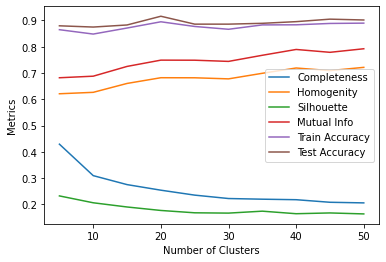

In [15]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
inertia = []
tr_acc = []
te_acc = []

for record in results_kmeans:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    inertia.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data2-KMeans-FS.png")

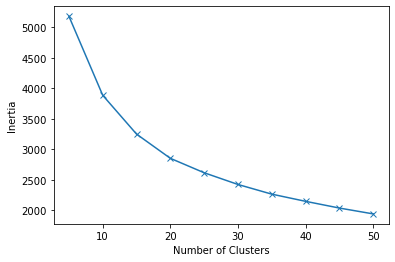

In [16]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.plot(ks, inertia, marker='x')
plt.savefig("Elbow-D2-ICA.png")

In [17]:
model = KMeans(n_clusters=10)
model.fit(X_train)
y_pred = model.predict(X_train)

mapping = list(zip(k_model.labels_, y_train))
mapper = {}
for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
    lst = [item[1] for item in list(group)]
    cls = max(set(lst),key=lst.count)
    mapper[key]=cls

y_class_pred = [mapper[i] for i in y_pred]

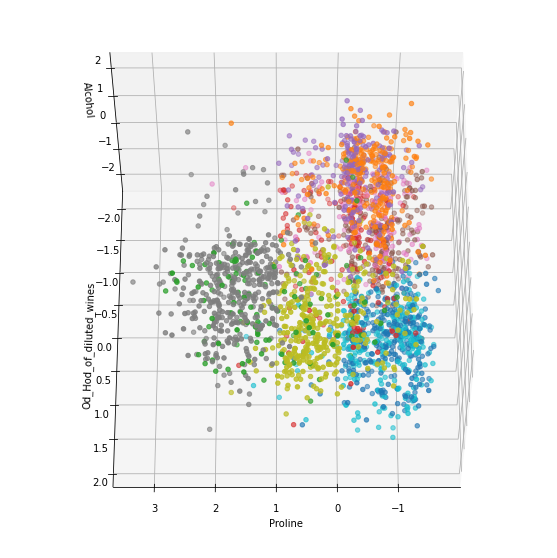

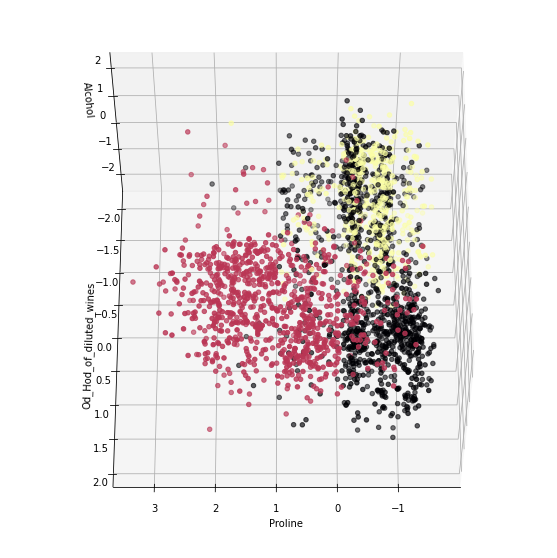

<Figure size 432x288 with 0 Axes>

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d') 
col = X_train.columns
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_pred, cmap='tab10')
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
ax.view_init(60, 90)
plt.savefig("D2-FS-KMEANS-ACT.png")

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')    
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_class_pred, cmap='inferno_r')
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
ax.view_init(60, 90)
plt.show()
plt.savefig("D2-FS-KMEANS-CLS.png")

### Expectation Maximization

In [37]:
results_gmm = []
for k in range(2, 31, 2):
    print(f"K={k}")
    g_model = GaussianMixture(n_components=k, random_state=7)
    g_model.fit(X_train)
    pred = g_model.predict(X_train)
    
    mapping = list(zip(pred, y_train))
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
    
    homogenity, completeness, _ = homogeneity_completeness_v_measure(pred, y_train)
    s_score = silhouette_score(X_train, pred)
    mi = mutual_info_score(y_train, pred)
    
    train_accuracy = get_score(g_model, X_train, y_train, mapper)
    test_accuracy = get_score(g_model, X_test, y_test, mapper)
    
    record = [k, homogenity, completeness, s_score, mi, g_model.score(X_train), train_accuracy, test_accuracy, 
              g_model.bic(X_train)]
    results_gmm.append(record)

with open("D2_EM_FS.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_gmm)

K=2
K=4
K=6
K=8
K=10
K=12
K=14
K=16
K=18
K=20
K=22
K=24
K=26
K=28
K=30


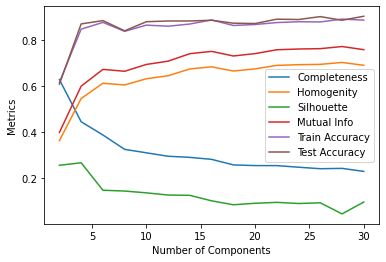

In [38]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
tr_acc = []
te_acc = []
scores = []
bic = []

for record in results_gmm:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    scores.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])
    bic.append(record[8])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data2-EM-FS.png")

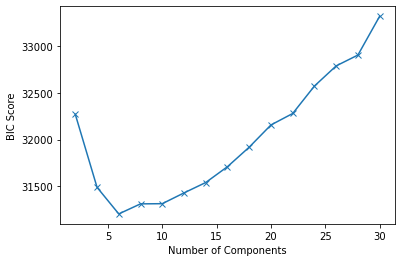

In [39]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.plot(ks, bic, marker='x')
plt.savefig("Cost-D2-FS.png")

In [40]:
model = GaussianMixture(n_components=6, random_state=7)
model.fit(X_train)
y_pred = model.predict(X_train)

mapping = list(zip(k_model.labels_, y_train))
mapper = {}
for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
    lst = [item[1] for item in list(group)]
    cls = max(set(lst),key=lst.count)
    mapper[key]=cls

y_class_pred = [mapper[i] for i in y_pred]

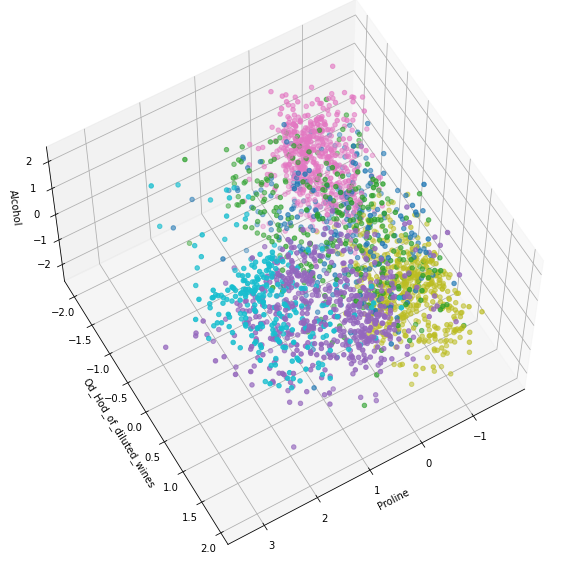

<Figure size 432x288 with 0 Axes>

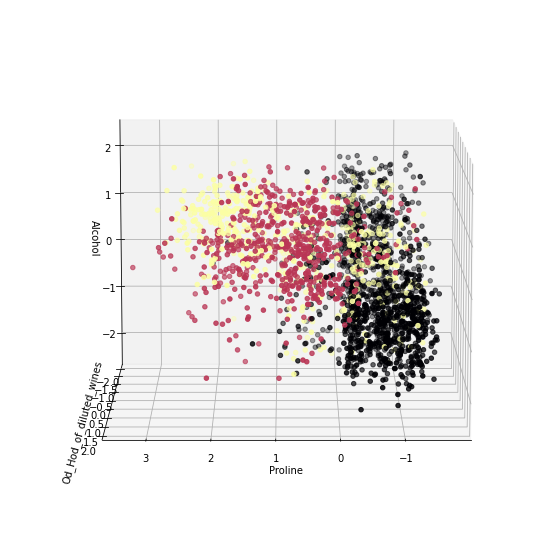

<Figure size 432x288 with 0 Axes>

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')    
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_pred, cmap='tab10')
ax.view_init(60, 60)
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
plt.show()
plt.savefig("D2-FS-GMM-ACT.png")

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')    
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_class_pred, cmap='inferno_r')
ax.view_init(10, 90)
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
plt.show()
plt.savefig("D2-FS-GMM-CLS.png")

# Phishing Websites Dataset

In [62]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes
    
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [64]:
forest = ExtraTreesClassifier(n_estimators = 250)
forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250)

In [65]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

1. SSLfinal_State (0.313368)
2. URL_of_Anchor (0.225668)
3. web_traffic (0.069550)
4. having_Sub_Domain (0.055785)
5. Prefix_Suffix (0.052876)
6. Links_in_tags (0.042127)
7. Request_URL (0.025632)
8. SFH (0.023218)
9. Links_pointing_to_page (0.020480)
10. Domain_registeration_length (0.018710)
11. age_of_domain (0.016981)
12. having_IP_Address (0.014828)
13. Page_Rank (0.013778)
14. DNSRecord (0.013315)
15. Google_Index (0.013045)
16. URL_Length (0.009482)
17. HTTPS_token (0.007364)
18. Submitting_to_email (0.006488)
19. Redirect (0.006315)
20. popUpWidnow (0.006136)
21. having_At_Symbol (0.005991)
22. Shortining_Service (0.005846)
23. Statistical_report (0.005787)
24. Abnormal_URL (0.005112)
25. Favicon (0.004964)
26. double_slash_redirecting (0.004780)
27. on_mouseover (0.004353)
28. port (0.003181)
29. Iframe (0.002914)
30. RightClick (0.001927)


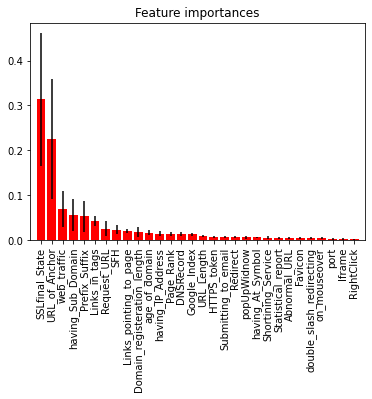

In [66]:
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(X.columns[indices], importances[indices],
        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xticks(rotation='vertical')
plt.show()

[0.8862190812720848, 0.9089752650176679, 0.9125088339222615, 0.9209893992932863, 0.929469964664311, 0.9368197879858657, 0.9413427561837456, 0.9454416961130742, 0.953356890459364, 0.9566077738515901, 0.9655123674911661, 0.9717314487632509, 0.9773851590106007, 0.9813427561837456, 0.9850176678445229, 0.9857243816254417, 0.9864310954063604, 0.9882685512367492, 0.9885512367491166, 0.9885512367491166, 0.9889752650176679, 0.9892579505300353, 0.9893992932862191, 0.9893992932862191, 0.9893992932862191, 0.9893992932862191, 0.9893992932862191, 0.9893992932862191, 0.9893992932862191, 0.9893992932862191]


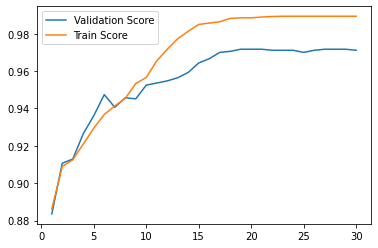

In [67]:
X_train_1, X_test_1, y_train_1, y_test_1 = \
    train_test_split(X_train, y_train, test_size=0.20, random_state=7)
train_score = []
test_score = []
for i, index in enumerate(indices):
    X_train_dup = X_train_1[X_train_1.columns[indices[:i+1]]]
    X_test_dup = X_test_1[X_test_1.columns[indices[:i+1]]]
    forest = ExtraTreesClassifier(n_estimators = 250)
    forest.fit(X_train_dup, y_train_1)
    
    train_score.append(forest.score(X_train_dup, y_train_1))
    test_score.append(forest.score(X_test_dup, y_test_1))

print(train_score)
plt.figure()
plt.plot(range(1, len(indices)+1, 1), test_score, label="Validation Score")
plt.plot(range(1, len(indices)+1, 1), train_score, label="Train Score")
plt.legend(loc='best')
plt.show()

In [68]:
X_train.columns[indices[:15]]

Index(['SSLfinal_State', 'URL_of_Anchor', 'web_traffic', 'having_Sub_Domain',
       'Prefix_Suffix', 'Links_in_tags', 'Request_URL', 'SFH',
       'Links_pointing_to_page', 'Domain_registeration_length',
       'age_of_domain', 'having_IP_Address', 'Page_Rank', 'DNSRecord',
       'Google_Index'],
      dtype='object')

### KMeans

In [69]:
results_kmeans = []
import collections
X_train = X_train[X_train.columns[indices[:15]]]
X_test = X_test[X_test.columns[indices[:15]]]

tot = collections.Counter(y_train)

for k in range(5, 51, 5):
    print(f"K={k}")
    k_model = KMeans(n_clusters=k, max_iter=500)
    k_model.fit(X_train)
    
    mapping = list(zip(k_model.labels_, y_train))
    mapper = {}
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
            
    homogenity, completeness, _ = homogeneity_completeness_v_measure(k_model.labels_, y_train)
    s_score = silhouette_score(X_train, k_model.labels_)
    mi = mutual_info_score(y_train, k_model.labels_)

    train_accuracy = get_score(k_model, X_train, y_train, mapper)
    test_accuracy = get_score(k_model, X_test, y_test, mapper)

    
    record = [k, homogenity, completeness, s_score, mi, k_model.inertia_, train_accuracy, test_accuracy]
    
    results_kmeans.append(record)
with open("D1_KM_FS.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_kmeans)

K=5
K=10
K=15
K=20
K=25
K=30
K=35
K=40
K=45
K=50


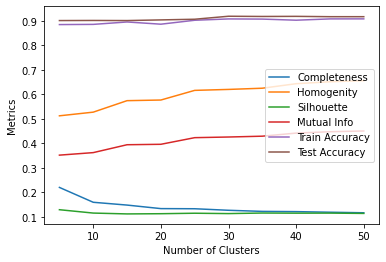

In [70]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
inertia = []
tr_acc = []
te_acc = []

for record in results_kmeans:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    inertia.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data1-KMeans_FS.png")

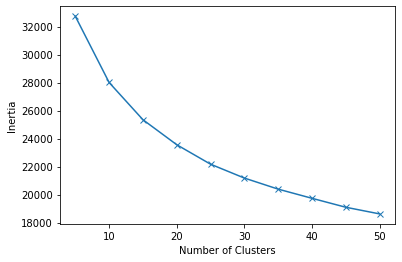

In [71]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.plot(ks, inertia, marker='x')
plt.savefig("Elbow-D1_FS.png")

In [72]:
model = KMeans(n_clusters=15)
model.fit(X_train)
y_pred = model.predict(X_train)

mapping = list(zip(k_model.labels_, y_train))
mapper = {}
for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
    lst = [item[1] for item in list(group)]
    cls = max(set(lst),key=lst.count)
    mapper[key]=cls

y_class_pred = [mapper[i] for i in y_pred]

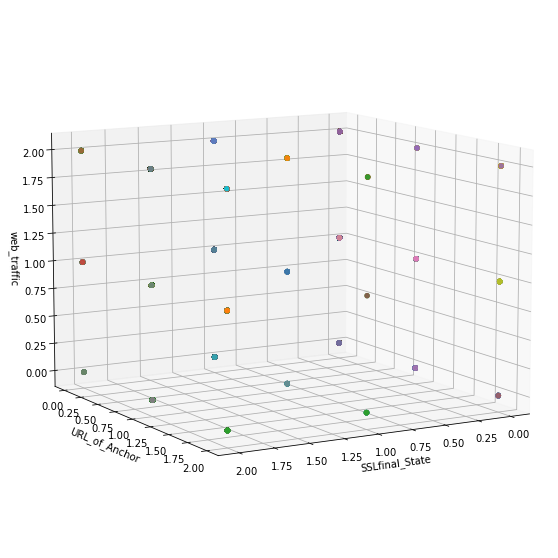

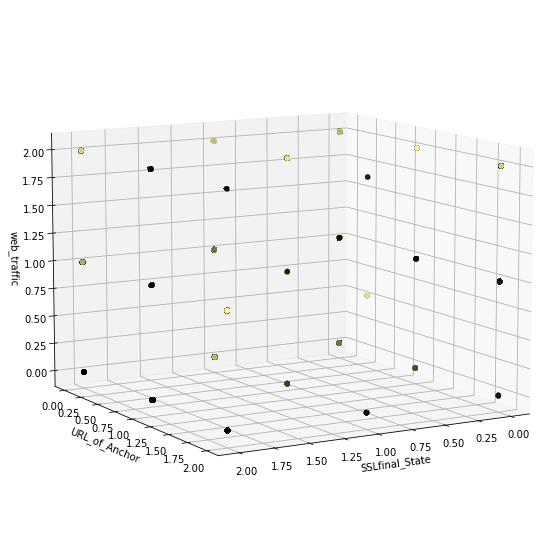

,SSLfinal_State,URL_of_Anchor,web_traffic,having_Sub_Domain,Prefix_Suffix,Links_in_tags,Request_URL,SFH,Links_pointing_to_page,Domain_registeration_length,age_of_domain,having_IP_Address,Page_Rank,DNSRecord,Google_Index
9879,2,1,1,2,0,0,0,0,2,0,1,0,0,1,1
10973,1,0,1,0,0,1,0,0,1,1,1,0,1,1,1
5069,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1
10765,2,2,0,0,0,0,0,0,2,1,1,0,0,1,1
10110,0,0,1,0,0,1,1,0,2,0,1,1,0,1,0


<Figure size 432x288 with 0 Axes>

In [75]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d') 
col = X_train.columns
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_pred, cmap='tab10')
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
ax.view_init(10, 60)
plt.savefig("D1-FS-KMEANS-ACT.png")

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')    
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_class_pred, cmap='inferno_r')
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
ax.view_init(10, 60)
plt.show()
plt.savefig("D1-FS-KMEANS-CLS.png")
X_train.head()

### Expectation Maximization

In [76]:
results_gmm = []
for k in range(2, 31, 2):
    print(f"K={k}")
    g_model = GaussianMixture(n_components=k, random_state=7)
    g_model.fit(X_train)
    pred = g_model.predict(X_train)
    
    mapping = list(zip(pred, y_train))
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
    
    homogenity, completeness, _ = homogeneity_completeness_v_measure(pred, y_train)
    s_score = silhouette_score(X_train, pred)
    mi = mutual_info_score(y_train, pred)
    
    train_accuracy = get_score(g_model, X_train, y_train, mapper)
    test_accuracy = get_score(g_model, X_test, y_test, mapper)
    
    record = [k, homogenity, completeness, s_score, mi, g_model.score(X_train), train_accuracy, test_accuracy, 
              g_model.bic(X_train)]
    results_gmm.append(record)

with open("D1_EM_FS.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_gmm)

K=2
K=4
K=6
K=8
K=10
K=12
K=14
K=16
K=18
K=20
K=22
K=24
K=26
K=28
K=30


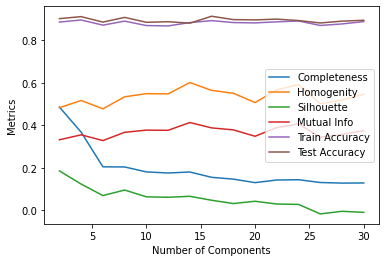

In [77]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
tr_acc = []
te_acc = []
scores = []
bic = []

for record in results_gmm:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    scores.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])
    bic.append(record[8])

    
plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data1-EM_FS.png")

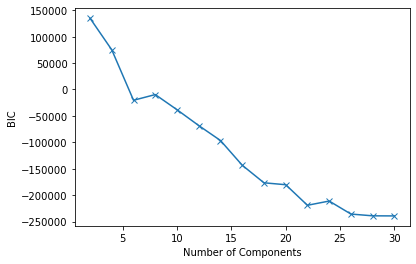

In [78]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.plot(ks, bic, marker='x')
plt.savefig("Cost-D1_FS.png")

In [79]:
model = GaussianMixture(n_components=24, random_state=7)
model.fit(X_train)
y_pred = model.predict(X_train)

mapping = list(zip(k_model.labels_, y_train))
mapper = {}
for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
    lst = [item[1] for item in list(group)]
    cls = max(set(lst),key=lst.count)
    mapper[key]=cls

y_class_pred = [mapper[i] for i in y_pred]

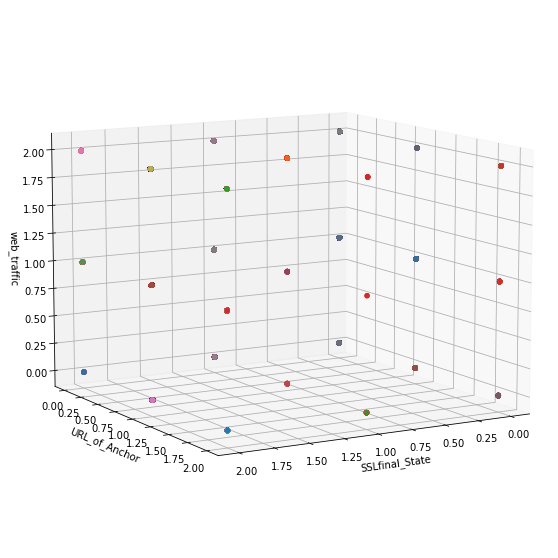

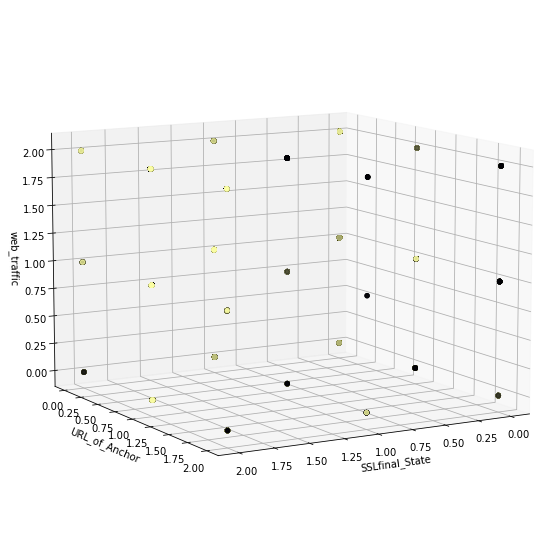

,SSLfinal_State,URL_of_Anchor,web_traffic,having_Sub_Domain,Prefix_Suffix,Links_in_tags,Request_URL,SFH,Links_pointing_to_page,Domain_registeration_length,age_of_domain,having_IP_Address,Page_Rank,DNSRecord,Google_Index
9879,2,1,1,2,0,0,0,0,2,0,1,0,0,1,1
10973,1,0,1,0,0,1,0,0,1,1,1,0,1,1,1
5069,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1
10765,2,2,0,0,0,0,0,0,2,1,1,0,0,1,1
10110,0,0,1,0,0,1,1,0,2,0,1,1,0,1,0


<Figure size 432x288 with 0 Axes>

In [80]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d') 
col = X_train.columns
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_pred, cmap='tab10')
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
ax.view_init(10, 60)
plt.savefig("D1-FS-GMM-ACT.png")

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')    
ax.scatter(X_train[col[0]], X_train[col[1]], X_train[col[2]], c=y_class_pred, cmap='inferno_r')
ax.set_xlabel(col[0])
ax.set_ylabel(col[1])
ax.set_zlabel(col[2])
ax.view_init(10, 60)
plt.show()
plt.savefig("D1-FS-GMM-CLS.png")
X_train.head()